In [19]:
import json

# Get number of tools per domain
domains = {
    "GorillaFileSystem": "gorilla_file_system.json",
    "MathAPI": "math_api.json",
    "MessageAPI": "message_api.json",
    "TwitterAPI": "posting_api.json",
    "TicketAPI": "ticket_api.json",
    "TradingBot": "trading_bot.json",
    "TravelAPI": "travel_booking.json",
    "VehicleControlAPI": "vehicle_control.json",
}
tools_base_path = "data/multi_turn_func_doc/"
tools_per_domain = {}
num_tools_per_domain = {}
for domain_name, domain_file in domains.items():
    with open(f"{tools_base_path}{domain_file}", "r") as f:
        tools = f.readlines()
        tools = [json.loads(line) for line in tools]
    tools_per_domain[domain_name] = tools
    num_tools_per_domain[domain_name] = len(tools)
    print(f"Domain {domain_name} has {len(tools)} tools/functions")

Domain GorillaFileSystem has 18 tools/functions
Domain MathAPI has 17 tools/functions
Domain MessageAPI has 10 tools/functions
Domain TwitterAPI has 14 tools/functions
Domain TicketAPI has 9 tools/functions
Domain TradingBot has 22 tools/functions
Domain TravelAPI has 17 tools/functions
Domain VehicleControlAPI has 22 tools/functions


In [20]:
def get_dataset_stats(dataset):
    dataset_stats = {
        "keys": dataset[0].keys(),
        "num_samples": len(dataset),
        "num_messages": [len(sample["question"]) for sample in dataset],
        "num_involved_domains": [len(sample["involved_classes"]) for sample in dataset],
        "num_tool_calls": [len(sample["path"]) for sample in dataset],
        "avg_num_messages": sum([len(sample["question"]) for sample in dataset]) / len(dataset) if dataset else 0,
        "max_num_messages": max([len(sample["question"]) for sample in dataset]) if dataset else 0,
        "min_num_messages": min([len(sample["question"]) for sample in dataset]) if dataset else 0,
        "avg_num_involved_domains": sum([len(sample["involved_classes"]) for sample in dataset]) / len(dataset) if dataset else 0,
        "max_num_involved_domains": max([len(sample["involved_classes"]) for sample in dataset]) if dataset else 0,
        "min_num_involved_domains": min([len(sample["involved_classes"]) for sample in dataset]) if dataset else 0,
        "avg_num_tool_calls": sum([len(sample["path"]) for sample in dataset]) / len(dataset) if dataset else 0,
        "max_num_tool_calls": max([len(sample["path"]) for sample in dataset]) if dataset else 0,
        "min_num_tool_calls": min([len(sample["path"]) for sample in dataset]) if dataset else 0,
    }
    # Get number of tools available per sample
    for sample in dataset:
        sample["num_tools_available"] = sum(num_tools_per_domain.get(domain_name, 0) for domain_name in sample["involved_classes"])
    dataset_stats["num_tools_available"] = [sample["num_tools_available"] for sample in dataset]
    dataset_stats["avg_num_tools_available"] = sum([sample["num_tools_available"] for sample in dataset]) / len(dataset) if dataset else 0
    dataset_stats["max_num_tools_available"] = max([sample["num_tools_available"] for sample in dataset]) if dataset else 0
    dataset_stats["min_num_tools_available"] = min([sample["num_tools_available"] for sample in dataset]) if dataset else 0

    return dataset_stats

In [21]:
import numpy as np
from copy import deepcopy

def extend_dataset_double_available_tools(dataset, new_tag="extended_double"):
    extended_dataset = deepcopy(dataset)

    prev_name = str(dataset[0]["id"]).split("_")[:-1]
    prev_name = "_".join(prev_name)
    print(f"Extending dataset with tag {new_tag} and previous name {prev_name}")
    new_tagged_name = f"{prev_name}_{new_tag}" if prev_name else new_tag

    for sample_index, sample in enumerate(extended_dataset):
        # Change sample id name
        sample["id"] = f"{new_tagged_name}_{sample['id'].split('_')[-1]}"
        sample["involved_classes_original"] = deepcopy(sample["involved_classes"])

        # Get all tools available for this sample
        num_tools_in_sample = sum([num_tools_per_domain.get(domain_name, 0) for domain_name in sample["involved_classes"]])
        target_num_tools = 2 * num_tools_in_sample

        print(f"Sample {sample_index} from {num_tools_in_sample} tools (with domains {sample['involved_classes']})", end=" ")

        # Let's try to double the number of tools available
        # Let's randomly pick a domain (not in the involved_classes) and add all its tools
        # Only consider domains in which the number of tools is less or equal than the target number of tools
        available_domains = [domain_name for domain_name, num_tools in num_tools_per_domain.items() if num_tools <= target_num_tools and domain_name not in sample["involved_classes"]]
        if not available_domains:
            print("No more domains available")
            # Get the domain with the least number of tools (but not in involved_classes) and add its tools
            available_domains = [domain_name for domain_name, num_tools in num_tools_per_domain.items() if domain_name not in sample["involved_classes"]]
            available_domains = [min(available_domains, key=lambda domain_name: num_tools_per_domain[domain_name])]
            min_tools_domain = available_domains[0]
            domain_tools = tools_per_domain[min_tools_domain]
            sample["involved_classes"].append(min_tools_domain)
            num_tools_in_sample += len(domain_tools)

        # Add tools while the number of tools is less than the target number of tools
        while num_tools_in_sample < target_num_tools and available_domains:
            domain_name = str(np.random.choice(available_domains))
            # Do not add the tool if the distance from the target number of tools will be greater than the current distance
            curr_distance = abs(num_tools_in_sample - target_num_tools)
            future_distance = abs(num_tools_in_sample + len(tools_per_domain[domain_name]) - target_num_tools)
            if future_distance >= curr_distance:
                # Remove from available domains and continue
                available_domains.remove(domain_name)
                continue
            available_domains.remove(domain_name)
            domain_tools = tools_per_domain[domain_name]
            sample["involved_classes"].append(domain_name)
            num_tools_in_sample += len(domain_tools)

        print(f"to {num_tools_in_sample} ({num_tools_in_sample - target_num_tools} far from target)", end=" ")
        print(f"has now domains {sample['involved_classes']}")

    # Check that there are not repeated "involved_classes"
    for sample in extended_dataset:
        assert len(sample["involved_classes"]) == len(set(sample["involved_classes"]))

    print(f"Extended dataset has {len(extended_dataset)} samples")

    return extended_dataset

In [22]:
def extend_dataset_full_available_tools(dataset, new_tag="extended_full"):
    extended_dataset = deepcopy(dataset)

    prev_name = str(dataset[0]["id"]).split("_")[:-1]
    prev_name = "_".join(prev_name)
    print(f"Extending dataset with tag {new_tag} and previous name {prev_name}")
    new_tagged_name = f"{prev_name}_{new_tag}" if prev_name else new_tag

    for sample_index, sample in enumerate(extended_dataset):
        # Change sample id name
        sample["id"] = f"{new_tagged_name}_{sample['id'].split('_')[-1]}"
        sample["involved_classes_original"] = deepcopy(sample["involved_classes"])

        # Add tools while the number of tools is less than the target number of tools
        target_num_tools = 128
        num_tools_in_sample = len(sample.get("involved_classes", []))
        available_domains = list(set(tools_per_domain.keys()).difference(set(sample["involved_classes"])))

        while num_tools_in_sample < target_num_tools and available_domains:
            domain_name = str(np.random.choice(available_domains))
            available_domains.remove(domain_name)
            domain_tools = tools_per_domain[domain_name]
            sample["involved_classes"].append(domain_name)
            num_tools_in_sample += len(domain_tools)

        print(f"to {num_tools_in_sample} ({num_tools_in_sample - target_num_tools} far from target)", end=" ")
        print(f"has now domains {sample['involved_classes']}")

    # Check that there are not repeated "involved_classes"
    for sample in extended_dataset:
        assert len(sample["involved_classes"]) == len(set(sample["involved_classes"]))

    print(f"Extended dataset has {len(extended_dataset)} samples")

    return extended_dataset

In [23]:
def extend_dataset_900_available_tools(dataset, new_tag="extended_900tools"):
    extended_dataset = deepcopy(dataset)

    prev_name = str(dataset[0]["id"]).split("_")[:-1]
    prev_name = "_".join(prev_name)
    print(f"Extending dataset with tag {new_tag} and previous name {prev_name}")
    new_tagged_name = f"{prev_name}_{new_tag}" if prev_name else new_tag

    for sample_index, sample in enumerate(extended_dataset):
        # Change sample id name
        sample["id"] = f"{new_tagged_name}_{sample['id'].split('_')[-1]}"

        # NOTE we will not add any more involved classes or tools in here, as we will be doing inside the running script
    
    print(f"Extended dataset has {len(extended_dataset)} samples")

    return extended_dataset

In [24]:
# Load jsonl file
import json
dataset_paths = {
    "multi_turn_base": "data/BFCL_v3_multi_turn_base.json",
    "multi_turn_long_context": "data/BFCL_v3_multi_turn_long_context.json"
}
datasets = {}
for dataset_name, dataset_path in dataset_paths.items():
    with open(dataset_path, "r") as f:
        dataset = f.readlines()
        dataset = [json.loads(line) for line in dataset]
    datasets[dataset_name] = dataset
    print(f"Loaded {dataset_name} dataset with {len(dataset)} samples")

# Check a sample of each dataset
onerows = {}
for dataset_name, dataset in datasets.items():
    onerows[dataset_name] = dataset[0]

onerow_multi_turn_long_context = onerows["multi_turn_long_context"]
onerow_multi_turn_base = onerows["multi_turn_base"]

Loaded multi_turn_base dataset with 200 samples
Loaded multi_turn_long_context dataset with 200 samples


In [25]:
# DATASETS STATS
# Get stats of base and base extended datasets
multi_turn_base_dataset_stats = get_dataset_stats(datasets["multi_turn_base"])
multi_turn_long_context_dataset_stats = get_dataset_stats(datasets["multi_turn_long_context"])

print("Base dataset stats:")
print(multi_turn_base_dataset_stats)
print("Long context dataset stats:")
print(multi_turn_long_context_dataset_stats)

Base dataset stats:
{'keys': dict_keys(['id', 'question', 'initial_config', 'path', 'involved_classes', 'num_tools_available']), 'num_samples': 200, 'num_messages': [4, 4, 5, 2, 3, 4, 5, 3, 4, 3, 5, 2, 3, 2, 4, 5, 3, 3, 3, 3, 2, 3, 4, 3, 4, 4, 3, 3, 3, 3, 2, 2, 2, 5, 2, 3, 3, 3, 2, 4, 4, 2, 3, 4, 3, 2, 1, 3, 3, 4, 1, 4, 4, 4, 3, 5, 3, 2, 4, 5, 5, 4, 4, 3, 2, 2, 4, 4, 5, 2, 2, 5, 5, 3, 2, 4, 2, 3, 2, 3, 5, 4, 3, 3, 2, 2, 3, 4, 3, 4, 4, 2, 5, 3, 3, 5, 2, 6, 3, 4, 2, 4, 6, 5, 2, 2, 4, 5, 5, 7, 6, 4, 5, 2, 5, 4, 6, 6, 5, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 5, 6, 7, 3, 2, 3, 4, 4, 4, 5, 2, 4, 5, 5, 4, 3, 5, 4, 2, 5, 5, 2, 3, 3, 5, 5, 2, 5, 3, 3, 3, 3, 3, 6, 2, 4, 5, 5, 5, 5, 2, 6, 3, 4, 4, 5, 2, 2, 2, 5, 4, 6, 5, 2, 6, 6, 3, 6, 4, 6, 3, 5, 5, 5, 4, 6, 4, 5, 3, 1, 5], 'num_involved_domains': [2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2

In [26]:
# MULTI TURN BASE DATASETS -----------------------------------------------------

# Extend the base dataset
multi_turn_base_extended_double_dataset = extend_dataset_double_available_tools(datasets["multi_turn_base"])
multi_turn_base_extended_full_dataset = extend_dataset_full_available_tools(datasets["multi_turn_base"])
multi_turn_base_extended_900tools_dataset = extend_dataset_900_available_tools(datasets["multi_turn_base"])

# Save extended datasets
# # Double
# extended_double_dataset_path = "data/BFCL_v3_multi_turn_base_extended_double.json"
# with open(extended_double_dataset_path, "w") as f:
#     for sample in multi_turn_base_extended_double_dataset:
#         f.write(json.dumps(sample) + "\n")
# # Full
# extended_full_dataset_path = "data/BFCL_v3_multi_turn_base_extended_full.json"
# with open(extended_full_dataset_path, "w") as f:
#     for sample in multi_turn_base_extended_full_dataset:
#         f.write(json.dumps(sample) + "\n")
# # 900
# extended_900_dataset_path = "data/BFCL_v3_multi_turn_base_extended_900tools.json"
# with open(extended_900_dataset_path, "w") as f:
#     for sample in multi_turn_base_extended_900tools_dataset:
#         f.write(json.dumps(sample) + "\n")

Extending dataset with tag extended_double and previous name multi_turn_base
Sample 0 from 32 tools (with domains ['TwitterAPI', 'GorillaFileSystem']) to 68 (4 far from target) has now domains ['TwitterAPI', 'GorillaFileSystem', 'TicketAPI', 'MathAPI', 'MessageAPI']
Sample 1 from 18 tools (with domains ['GorillaFileSystem']) to 35 (-1 far from target) has now domains ['GorillaFileSystem', 'MathAPI']
Sample 2 from 27 tools (with domains ['TicketAPI', 'GorillaFileSystem']) to 49 (-5 far from target) has now domains ['TicketAPI', 'GorillaFileSystem', 'TradingBot']
Sample 3 from 18 tools (with domains ['GorillaFileSystem']) to 35 (-1 far from target) has now domains ['GorillaFileSystem', 'TravelAPI']
Sample 4 from 32 tools (with domains ['TwitterAPI', 'GorillaFileSystem']) to 64 (0 far from target) has now domains ['TwitterAPI', 'GorillaFileSystem', 'MessageAPI', 'TradingBot']
Sample 5 from 32 tools (with domains ['TwitterAPI', 'GorillaFileSystem']) to 64 (0 far from target) has now domain

In [27]:
# MULTI TURN BASE DATASETS POSSIBLE ANSWERS -------------------------------------
import json

# Generate the possible answer file for the extended dataset
multi_turn_base_possible_answers_path_dict = {}
multi_turn_base_possible_answers_path_dict["multi_turn_base"] = "data/possible_answer/BFCL_v3_multi_turn_base.json"
multi_turn_base_possible_answers_path_dict["multi_turn_base_extended_double"] = "data/possible_answer/BFCL_v3_multi_turn_base_extended_double.json"
multi_turn_base_possible_answers_path_dict["multi_turn_base_extended_full"] = "data/possible_answer/BFCL_v3_multi_turn_base_extended_full.json"
multi_turn_base_possible_answers_path_dict["multi_turn_base_extended_900tools"] = "data/possible_answer/BFCL_v3_multi_turn_base_extended_900tools.json"

# Load possible answers from base category
with open(multi_turn_base_possible_answers_path_dict["multi_turn_base"], "r") as f:
    possible_answers_base = f.readlines()
    possible_answers_base = [json.loads(line) for line in possible_answers_base]

sample_possible_answer_base = possible_answers_base[0]

# Save possible answers datasets
# prev_name = str(possible_answers_base[0]["id"]).split("_")[:-1]
# prev_name = "_".join(prev_name)
# # Double
# for sample in possible_answers_base:
#     sample["id"] = f"{prev_name}_extended_double_{sample['id'].split('_')[-1]}"
# with open(multi_turn_base_possible_answers_path_dict["multi_turn_base_extended_double"], "w") as f:
#     for sample in possible_answers_base:
#         f.write(json.dumps(sample) + "\n")
# # Full
# for sample in possible_answers_base:
#     sample["id"] = f"{prev_name}_extended_full_{sample['id'].split('_')[-1]}"
# with open(multi_turn_base_possible_answers_path_dict["multi_turn_base_extended_full"], "w") as f:
#     for sample in possible_answers_base:
#         f.write(json.dumps(sample) + "\n")
# # 900
# for sample in possible_answers_base:
#     sample["id"] = f"{prev_name}_extended_900tools_{sample['id'].split('_')[-1]}"
# with open(multi_turn_base_possible_answers_path_dict["multi_turn_base_extended_900tools"], "w") as f:
#     for sample in possible_answers_base:
#         f.write(json.dumps(sample) + "\n")

In [28]:
# MULTI TURN LONG CONTEXT DATASETS ---------------------------------------------
# Extend the long context dataset
multi_turn_long_context_extended_double_dataset = extend_dataset_double_available_tools(datasets["multi_turn_long_context"])
multi_turn_long_context_extended_full_dataset = extend_dataset_full_available_tools(datasets["multi_turn_long_context"])
multi_turn_long_context_extended_900tools_dataset = extend_dataset_900_available_tools(datasets["multi_turn_long_context"])

# Get stats of base and extended datasets
multi_turn_long_context_dataset_stats = get_dataset_stats(datasets["multi_turn_long_context"])
multi_turn_long_context_extended_double_dataset_stats = get_dataset_stats(multi_turn_long_context_extended_double_dataset)
multi_turn_long_context_extended_full_dataset_stats = get_dataset_stats(multi_turn_long_context_extended_full_dataset)
multi_turn_long_context_extended_900tools_dataset_stats = get_dataset_stats(multi_turn_long_context_extended_900tools_dataset)

print("Base dataset stats:")
print(multi_turn_long_context_dataset_stats)
print("Extended double dataset stats:")
print(multi_turn_long_context_extended_double_dataset_stats)
print("Extended full dataset stats:")
print(multi_turn_long_context_extended_full_dataset_stats)
print("Extended 900 dataset stats:")
print(multi_turn_long_context_extended_900tools_dataset_stats)

# Save extended datasets
# # Double
# extended_double_dataset_path = "data/BFCL_v3_multi_turn_long_context_extended_double.json"
# with open(extended_double_dataset_path, "w") as f:
#     for sample in multi_turn_long_context_extended_double_dataset:
#         f.write(json.dumps(sample) + "\n")
# # Full
# extended_full_dataset_path = "data/BFCL_v3_multi_turn_long_context_extended_full.json"
# with open(extended_full_dataset_path, "w") as f:
#     for sample in multi_turn_long_context_extended_full_dataset:
#         f.write(json.dumps(sample) + "\n")
# # 900
# extended_900_dataset_path = "data/BFCL_v3_multi_turn_long_context_extended_900tools.json"
# with open(extended_900_dataset_path, "w") as f:
#     for sample in multi_turn_long_context_extended_900tools_dataset:
#         f.write(json.dumps(sample) + "\n")

Extending dataset with tag extended_double and previous name multi_turn_long_context
Sample 0 from 32 tools (with domains ['TwitterAPI', 'GorillaFileSystem']) to 66 (2 far from target) has now domains ['TwitterAPI', 'GorillaFileSystem', 'TravelAPI', 'MathAPI']
Sample 1 from 18 tools (with domains ['GorillaFileSystem']) to 42 (6 far from target) has now domains ['GorillaFileSystem', 'MessageAPI', 'TwitterAPI']
Sample 2 from 27 tools (with domains ['TicketAPI', 'GorillaFileSystem']) to 59 (5 far from target) has now domains ['TicketAPI', 'GorillaFileSystem', 'MessageAPI', 'TradingBot']
Sample 3 from 18 tools (with domains ['GorillaFileSystem']) to 35 (-1 far from target) has now domains ['GorillaFileSystem', 'TravelAPI']
Sample 4 from 32 tools (with domains ['TwitterAPI', 'GorillaFileSystem']) to 63 (-1 far from target) has now domains ['TwitterAPI', 'GorillaFileSystem', 'TicketAPI', 'TradingBot']
Sample 5 from 32 tools (with domains ['TwitterAPI', 'GorillaFileSystem']) to 66 (2 far from

In [29]:
# MULTI TURN LONG CONTEXT DATASETS POSSIBLE ANSWERS -----------------------------
import json

# Generate the possible answer file for the extended dataset
multi_turn_long_context_possible_answers_path_dict = {}
multi_turn_long_context_possible_answers_path_dict["multi_turn_long_context"] = "data/possible_answer/BFCL_v3_multi_turn_long_context.json"
multi_turn_long_context_possible_answers_path_dict["multi_turn_long_context_extended_double"] = "data/possible_answer/BFCL_v3_multi_turn_long_context_extended_double.json"
multi_turn_long_context_possible_answers_path_dict["multi_turn_long_context_extended_full"] = "data/possible_answer/BFCL_v3_multi_turn_long_context_extended_full.json"
multi_turn_long_context_possible_answers_path_dict["multi_turn_long_context_extended_900tools"] = "data/possible_answer/BFCL_v3_multi_turn_long_context_extended_900tools.json"

# Load possible answers from base category
with open(multi_turn_long_context_possible_answers_path_dict["multi_turn_long_context"], "r") as f:
    possible_answers_long_context = f.readlines()
    possible_answers_long_context = [json.loads(line) for line in possible_answers_long_context]

sample_possible_answer_long_context = possible_answers_long_context[0]

# Save possible answers datasets
# prev_name = str(possible_answers_long_context[0]["id"]).split("_")[:-1]
# prev_name = "_".join(prev_name)
# # Double
# for sample in possible_answers_long_context:
#     sample["id"] = f"{prev_name}_extended_double_{sample['id'].split('_')[-1]}"
# with open(multi_turn_long_context_possible_answers_path_dict["multi_turn_long_context_extended_double"], "w") as f:
#     for sample in possible_answers_long_context:
#         f.write(json.dumps(sample) + "\n")
# # Full
# for sample in possible_answers_long_context:
#     sample["id"] = f"{prev_name}_extended_full_{sample['id'].split('_')[-1]}"
# with open(multi_turn_long_context_possible_answers_path_dict["multi_turn_long_context_extended_full"], "w") as f:
#     for sample in possible_answers_long_context:
#         f.write(json.dumps(sample) + "\n")
# # 900
# for sample in possible_answers_long_context:
#     sample["id"] = f"{prev_name}_extended_900tools_{sample['id'].split('_')[-1]}"
# with open(multi_turn_long_context_possible_answers_path_dict["multi_turn_long_context_extended_900tools"], "w") as f:
#     for sample in possible_answers_long_context:
#         f.write(json.dumps(sample) + "\n")

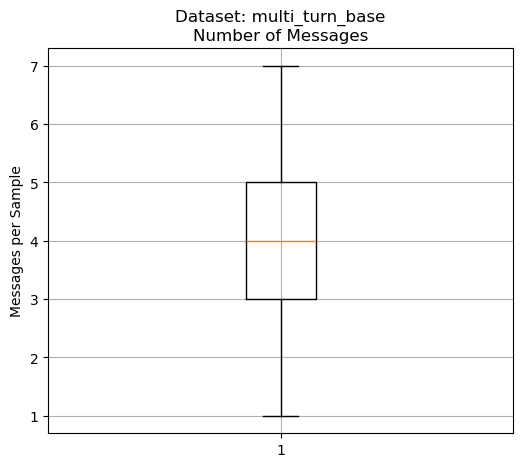

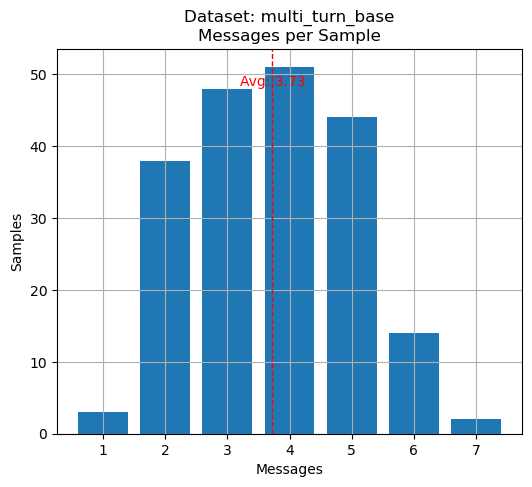

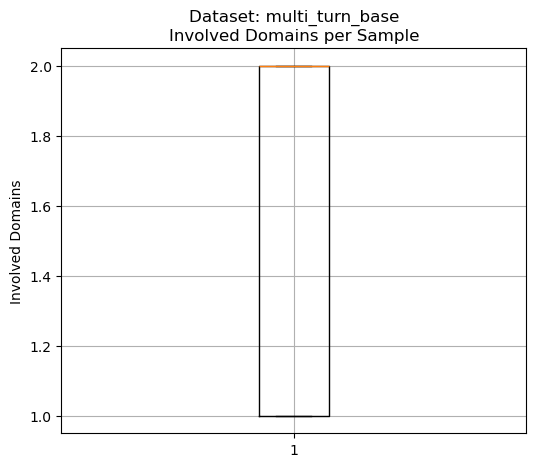

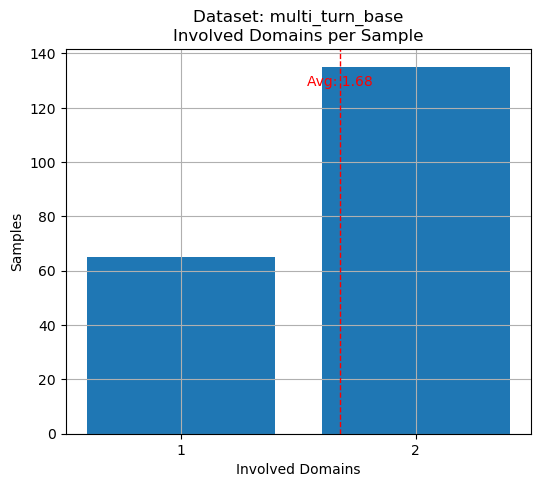

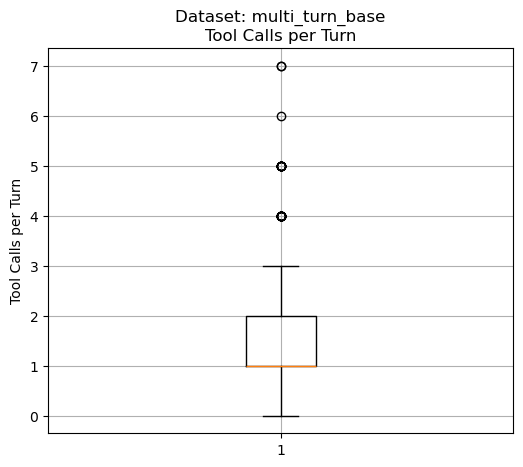

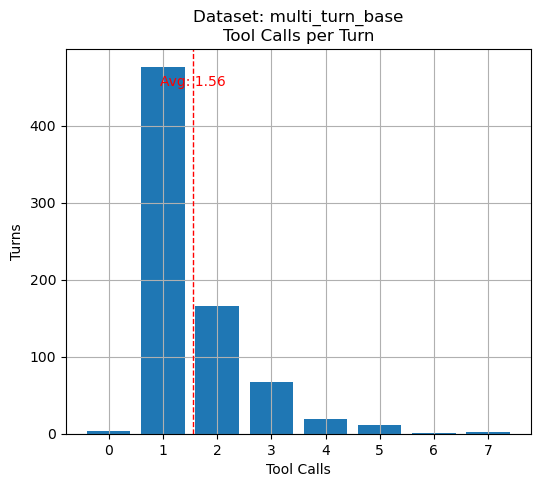

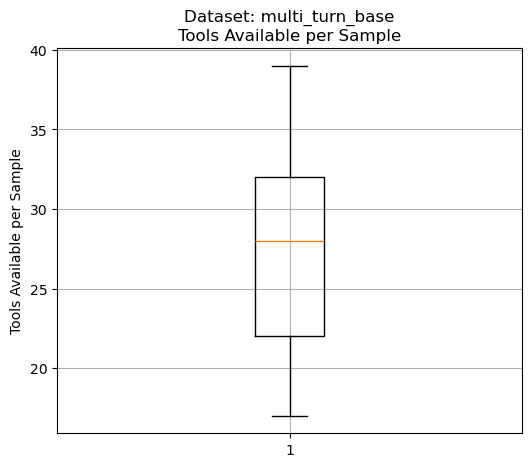

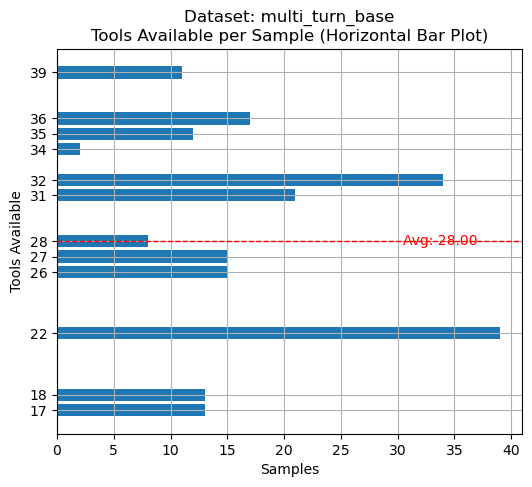

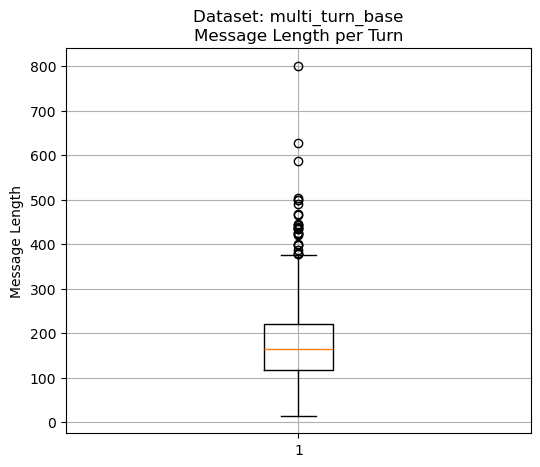

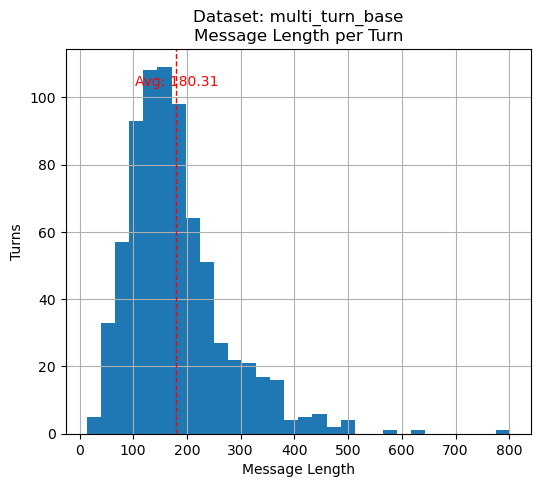

Sample multi_turn_long_context_38 has a turn with 34 tool calls:
["cd(folder='SuperResearch')", "rm(file_name='findings_report')", "rm(file_name='image_5421509146842474663.jpg')", "rm(file_name='image_185391401034246046.jpg')", "rm(file_name='image_6824007961180780019.jpg')", "rm(file_name='image_2994974694593273051.jpg')", "rm(file_name='image_2537728455072851196.jpg')", "rm(file_name='image_2164918946836800275.jpg')", "rm(file_name='image_1745133864906284051.jpg')", "rm(file_name='image_7707563551789432679.jpg')", "rm(file_name='image_8190489168166590809.jpg')", "rm(file_name='image_2385660725381355820.jpg')", "rm(file_name='image_4771211633166048374.jpg')", "rm(file_name='image_3443718094055823214.jpg')", "rm(file_name='image_6838087561356843690.jpg')", "rm(file_name='image_605952633285970710.jpg')", "rm(file_name='image_6341510244180179744.jpg')", "rm(file_name='image_4119241148692325954.jpg')", "rm(file_name='image_5651066601163181955.jpg')", "rm(file_name='image_37470913337513950

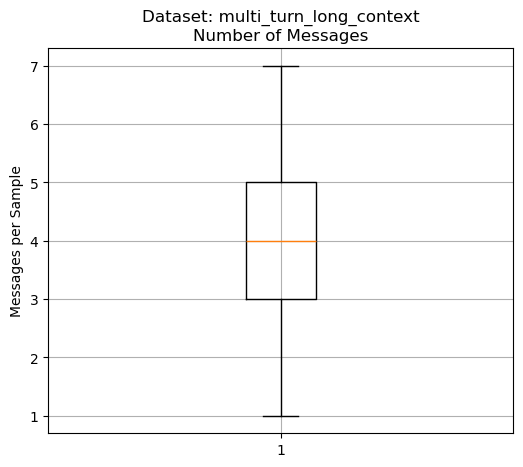

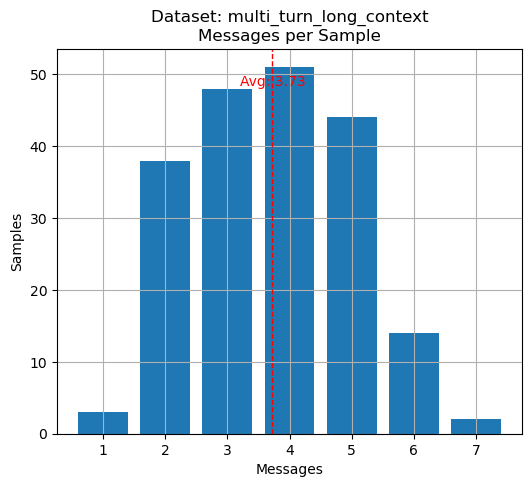

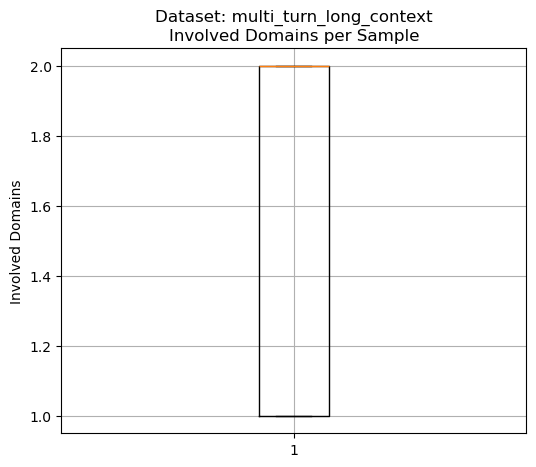

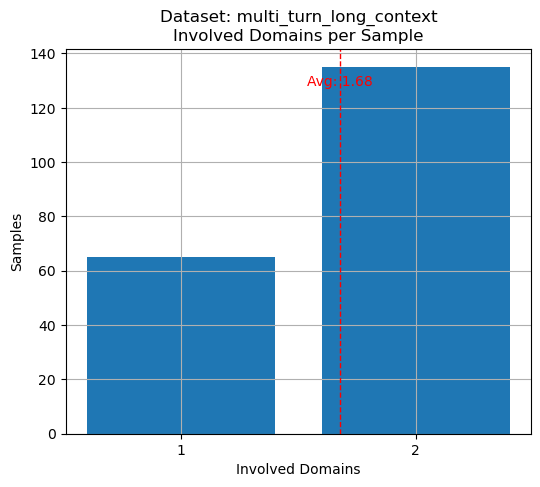

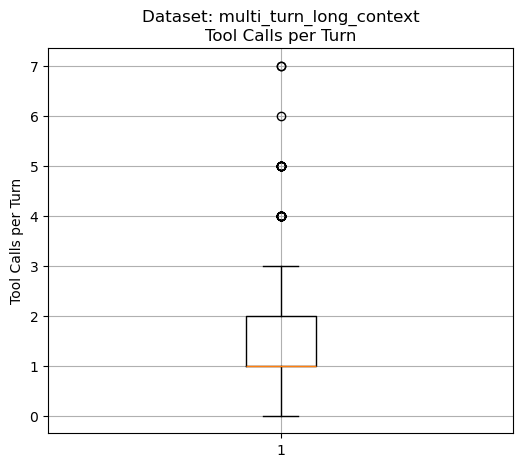

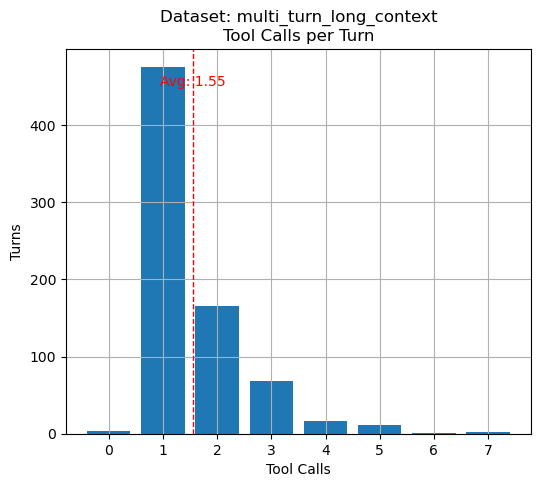

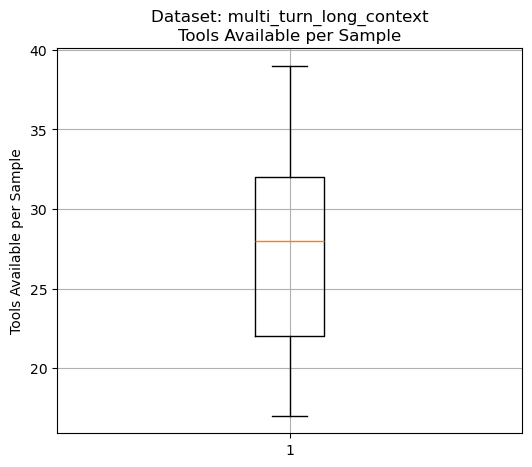

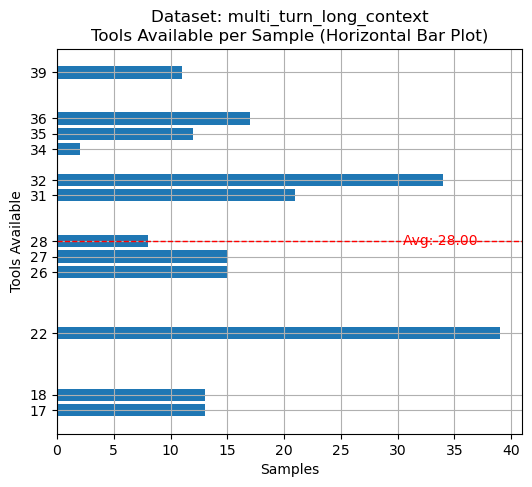

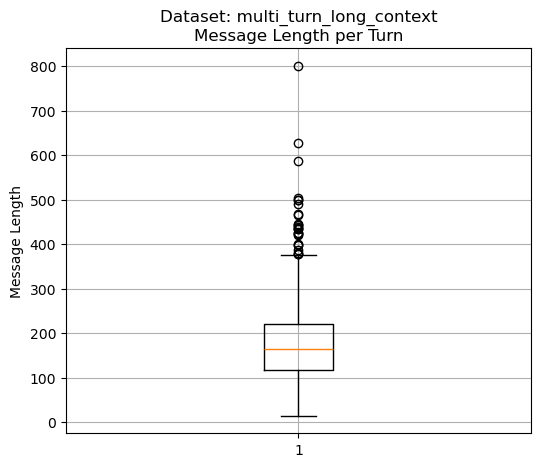

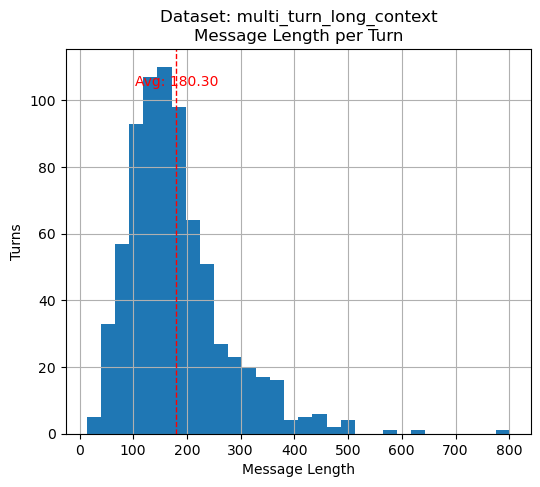

In [60]:
import numpy as np

# Generate box plots and histograms for the datasets
# 1. Number of messages
#   - This one can be taken from the dataset stats dictionary
#     it is the "num_messages" list that shows the number of messages per sample
# 2. Number of involved domains
#   - This one can be taken from the dataset stats dictionary
#     it is the "num_involved_domains" list that shows the number of messages per sample
# 3. Number of tool calls per turn
#   - This one can be taken from the possible answers dataset
#     We will take the "ground_truth" list, where each item in the list represents a turn
#     and the number of tool calls is the length of the turn list
# 4. Number of tools available per sample
#   - This one can be taken from the dataset stats dictionary
#     it is the "num_tools_available" list that shows the number of tools available per sample
# 5. Message length
#   - This one has to be computed from scratch
#     We will take the "question" list from the dataset, where each item in the list represents a message
#     and the message length is the length of the message list

import matplotlib.pyplot as plt

for dataset_name, dataset in datasets.items():
    if dataset_name == "multi_turn_base":
        dataset_stats = multi_turn_base_dataset_stats
        possible_answers = possible_answers_base
    elif dataset_name == "multi_turn_long_context":
        dataset_stats = multi_turn_long_context_dataset_stats
        possible_answers = possible_answers_long_context
    else:
        raise ValueError(f"Dataset name {dataset_name} not recognized")
    
    # Extract number of tool calls per turn from the possible answers dataset.
    tool_calls_per_turn = []
    for answer in possible_answers:
        for turn in answer["ground_truth"]:
            if len(turn) > 30:
                print(f"Sample {answer['id']} has a turn with {len(turn)} tool calls:\n{turn}")
            else:
                tool_calls_per_turn.append(len(turn))

    # 1. Number of Messages
    plt.figure(figsize=(6, 5))
    plt.boxplot(dataset_stats["num_messages"])
    plt.title(f"Dataset: {dataset_name}\nNumber of Messages")
    plt.ylabel("Messages per Sample")
    plt.grid()
    plt.show()
    # Bar plot with average vertical line for Number of Messages
    plt.figure(figsize=(6, 5))
    values, counts = np.unique(dataset_stats["num_messages"], return_counts=True)
    plt.bar(values, counts)
    plt.title(f"Dataset: {dataset_name}\nMessages per Sample")
    plt.xlabel("Messages")
    plt.ylabel("Samples")
    plt.xticks(np.arange(min(values), max(values)+1))
    avg_messages = sum(dataset_stats["num_messages"]) / len(dataset_stats["num_messages"])
    plt.axvline(avg_messages, color='red', linestyle='dashed', linewidth=1, label='Average')
    plt.text(avg_messages, max(counts)*0.95, f'Avg: {avg_messages:.2f}', color='red', ha='center')
    plt.grid()
    plt.show()

    # 2. Number of Involved Domains
    plt.figure(figsize=(6, 5))
    plt.boxplot(dataset_stats["num_involved_domains"])
    plt.title(f"Dataset: {dataset_name}\nInvolved Domains per Sample")
    plt.ylabel("Involved Domains")
    plt.grid()
    plt.show()
    # Bar plot with average vertical line
    plt.figure(figsize=(6, 5))
    values, counts = np.unique(dataset_stats["num_involved_domains"], return_counts=True)
    plt.bar(values, counts)
    plt.title(f"Dataset: {dataset_name}\nInvolved Domains per Sample")
    plt.xlabel("Involved Domains")
    plt.ylabel("Samples")
    plt.xticks(np.arange(min(values), max(values)+1))
    avg_involved_domains = sum(dataset_stats["num_involved_domains"]) / len(dataset_stats["num_involved_domains"])
    plt.axvline(avg_involved_domains, color='red', linestyle='dashed', linewidth=1, label='Average')
    plt.text(avg_involved_domains, max(counts)*0.95, f'Avg: {avg_involved_domains:.2f}', color='red', ha='center')
    plt.grid()
    plt.show()

    # 3. Number of Tool Calls per Turn
    plt.figure(figsize=(6, 5))
    plt.boxplot(tool_calls_per_turn)
    plt.title(f"Dataset: {dataset_name}\nTool Calls per Turn")
    plt.ylabel("Tool Calls per Turn")
    plt.grid()
    plt.show()
    # Bar plot for Number of Tool Calls per Turn with average vertical line
    values, counts = np.unique(tool_calls_per_turn, return_counts=True)
    plt.figure(figsize=(6, 5))
    plt.bar(values, counts)
    plt.title(f"Dataset: {dataset_name}\nTool Calls per Turn")
    plt.xlabel("Tool Calls")
    plt.ylabel("Turns")
    plt.xticks(np.arange(min(values), max(values)+1))
    avg_tool_calls = sum(tool_calls_per_turn) / len(tool_calls_per_turn)
    plt.axvline(avg_tool_calls, color='red', linestyle='dashed', linewidth=1, label='Average')
    plt.text(avg_tool_calls, max(counts)*0.95, f'Avg: {avg_tool_calls:.2f}', color='red', ha='center')
    plt.grid()
    plt.show()

    # 4. Number of Tools Available per Sample
    plt.figure(figsize=(6, 5))
    plt.boxplot(dataset_stats["num_tools_available"])
    plt.title(f"Dataset: {dataset_name}\nTools Available per Sample")
    plt.ylabel("Tools Available per Sample")
    plt.grid()
    plt.show()
    # Bar plot with average horizontal line for Number of Tools Available per Sample
    plt.figure(figsize=(6, 5))
    values, counts = np.unique(dataset_stats["num_tools_available"], return_counts=True)
    plt.barh(values, counts)
    plt.title(f"Dataset: {dataset_name}\nTools Available per Sample (Horizontal Bar Plot)")
    plt.xlabel("Samples")
    plt.ylabel("Tools Available")
    plt.yticks(values)  # Ensure y-ticks correspond to the unique values
    avg_tools_available = sum(dataset_stats["num_tools_available"]) / len(dataset_stats["num_tools_available"])
    plt.axhline(avg_tools_available, color='red', linestyle='dashed', linewidth=1, label='Average')
    plt.text(max(counts)*0.95, avg_tools_available, f'Avg: {avg_tools_available:.2f}', color='red', va='center', ha='right')
    plt.grid()
    plt.show()

    # 5. Message Length
    message_lengths = []
    for sample in dataset:
        for turn in sample["question"]:
            content = turn[0]["content"]
            message_lengths.append(len(content))
    plt.figure(figsize=(6, 5))
    plt.boxplot(message_lengths)
    plt.title(f"Dataset: {dataset_name}\nMessage Length per Turn")
    plt.ylabel("Message Length")
    plt.grid()
    plt.show()
    # Histogram with 30 bins for Message Length
    plt.figure(figsize=(6, 5))
    n, bins, patches = plt.hist(message_lengths, bins=30)
    plt.title(f"Dataset: {dataset_name}\nMessage Length per Turn")
    plt.xlabel("Message Length")
    plt.ylabel("Turns")
    avg_message_length = sum(message_lengths) / len(message_lengths) if message_lengths else 0
    plt.axvline(avg_message_length, color='red', linestyle='dashed', linewidth=1, label='Average')
    plt.text(avg_message_length, max(n)*0.95, f'Avg: {avg_message_length:.2f}', color='red', ha='center')
    plt.grid()
    plt.show()